In [1]:
import pandas as pd 

from gptchem.gpt_classifier import GPTClassifier
from gptchem.tuner import Tuner
from gptchem.formatter import RegressionFormatter
from sklearn.model_selection import train_test_split

from pycm import ConfusionMatrix

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import pickle


/u/g/m/gmerz2/miniconda3/envs/chemGPT/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING = {
    "t5": ["q", "v"],
    "mt5": ["q", "v"],
    "bart": ["q_proj", "v_proj"],
    "gpt2": ["c_attn"],
    "bloom": ["query_key_value"],
    "blip-2": ["q", "v", "q_proj", "v_proj"],
    "opt": ["q_proj", "v_proj"],
    "gptj": ["q_proj", "v_proj"],
    "gpt_neox": ["query_key_value"],
    "gpt_neo": ["q_proj", "v_proj"],
    "bert": ["query", "value"],
    "roberta": ["query", "value"],
    "xlm-roberta": ["query", "value"],
    "electra": ["query", "value"],
    "deberta-v2": ["query_proj", "value_proj"],
    "deberta": ["in_proj"],
    "layoutlm": ["query", "value"],
    "llama": ["q_proj", "v_proj"],
    "chatglm": ["query_key_value"],
}

In [3]:
import os
import sys
from typing import List

import fire
import torch
import transformers

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)
from datasets import Dataset

from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

2023-04-10 15:07:00.248980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 15:07:06.840439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /u/g/m/gmerz2/miniconda3/envs/chemGPT/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/u/g/m/gmerz2/miniconda3/envs/chemGPT/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /u/g/m/gmerz2/miniconda3 did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/u/g/m/gmerz2/miniconda3/envs/chemGPT/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {Path('FILE')}
  warn(msg)
/u/g/m/gmerz2/miniconda3/envs/chemGPT/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {Path('/run/user/2289/docker.sock'), Path('unix')}
  warn(msg)
/u/g/m/gmerz2/miniconda3/envs/chemGPT/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {Path('//matplotlib_inline.backend_inline'), Path('module')}
  warn(msg)


In [4]:
#get the data
def get_data():
    with open("qm9_key_smiles_0_val_u0_atom_b3lyp.pickle", 'rb') as pickle_file:
        pickled_data=pickle.load(pickle_file)
    raw_data = pd.DataFrame(list(pickled_data.items()), columns=["SMILES", "B3LYP atomization energy in kcal/mol"])
    formatter = RegressionFormatter(representation_column='SMILES',
        label_column='B3LYP atomization energy in kcal/mol',
        property_name='atomization energy in kcal/mol',
        num_digits=4
        )
    data = formatter.format_many(raw_data).drop(columns=["label","representation"], axis=1)
    df_trainval, df_test = train_test_split(data, test_size=100, train_size=900, random_state=42)
    df_train, df_val = train_test_split(df_trainval,test_size=100, shuffle=True)
    return df_train, df_val, df_test

In [5]:
def train(
    #dataframes
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    # model/data params
    base_model: str = "gpt2",  # the only required argument
    data_path: str = "qm9_key_smiles_0_val_u0_atom_b3lyp.pickle",
    output_dir: str = "outputs",
    # training hyperparams
    batch_size: int = 128,
    micro_batch_size: int = 4,
    num_epochs: int = 3,
    learning_rate: float = 3e-4,
    cutoff_len: int = 256,
    # lora hyperparams
    lora_r: int = 8,
    lora_alpha: int = 16,
    lora_dropout: float = 0.05,
    lora_target_modules: List[str] = [""],
    # llm hyperparams
    train_on_inputs: bool = True,  # if False, masks out inputs in loss
    group_by_length: bool = False,  # faster, but produces an odd training loss curve
    # wandb params
    wandb_project: str = "",
    wandb_run_name: str = "",
    wandb_watch: str = "",  # options: false | gradients | all
    wandb_log_model: str = "",  # options: false | true
    resume_from_checkpoint: str = None,  # either training checkpoint or final adapter
    prompt_template_name: str = "chemgpt",  # The prompt template to use, will default to alpaca.
):
    
    lora_target_modules = TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING[base_model]
    if int(os.environ.get("LOCAL_RANK", 0)) == 0:
        print(
            f"Training LoRA model with params:\n"
            f"base_model: {base_model}\n"
            f"data_path: {data_path}\n"
            f"output_dir: {output_dir}\n"
            f"batch_size: {batch_size}\n"
            f"micro_batch_size: {micro_batch_size}\n"
            f"num_epochs: {num_epochs}\n"
            f"learning_rate: {learning_rate}\n"
            f"cutoff_len: {cutoff_len}\n"
            f"lora_r: {lora_r}\n"
            f"lora_alpha: {lora_alpha}\n"
            f"lora_dropout: {lora_dropout}\n"
            f"lora_target_modules: {lora_target_modules}\n"
            f"train_on_inputs: {train_on_inputs}\n"
            f"group_by_length: {group_by_length}\n"
            f"wandb_project: {wandb_project}\n"
            f"wandb_run_name: {wandb_run_name}\n"
            f"wandb_watch: {wandb_watch}\n"
            f"wandb_log_model: {wandb_log_model}\n"
            f"resume_from_checkpoint: {resume_from_checkpoint or False}\n"
            f"prompt template: {prompt_template_name}\n"
        )
    assert (
        base_model
    ), "Please specify a --base_model, e.g. --base_model='gpt2'"
    gradient_accumulation_steps = batch_size // micro_batch_size

    device_map = "auto"
    world_size = int(os.environ.get("WORLD_SIZE", 1))
    ddp = world_size != 1
    if ddp:
        device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
        gradient_accumulation_steps = gradient_accumulation_steps // world_size

    # Check if parameter passed or if set within environ
    use_wandb = len(wandb_project) > 0 or (
        "WANDB_PROJECT" in os.environ and len(os.environ["WANDB_PROJECT"]) > 0
    )
    # Only overwrite environ if wandb param passed
    if len(wandb_project) > 0:
        os.environ["WANDB_PROJECT"] = wandb_project
    if len(wandb_watch) > 0:
        os.environ["WANDB_WATCH"] = wandb_watch
    if len(wandb_log_model) > 0:
        os.environ["WANDB_LOG_MODEL"] = wandb_log_model

    #set up the model and tokenizer    
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    # might not be optimal, just trying to run the code
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        base_model, 
        load_in_8bit=False,
        torch_dtype=torch.float16,
        device_map='auto',
    )    
    def tokenize(prompt):
        result = tokenizer(
            prompt,
            truncation=True,
            max_length=cutoff_len,
            padding=True,
            return_tensors=None,
        )
        return result
    
    def tokenize_prompt(data_point):
        full_prompt = data_point["prompt"]+data_point["completion"]
        tokenized_full_prompt = tokenize(full_prompt)
        return tokenized_full_prompt

    model = prepare_model_for_int8_training(model)

    config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=lora_target_modules,
        lora_dropout=lora_dropout,
        bias="none",
        task_type="CAUSAL_LM",
    )
    model = get_peft_model(model, config)

    train_data = Dataset.from_pandas(df_train).shuffle().map(tokenize_prompt)
    val_data = Dataset.from_pandas(df_val).shuffle().map(tokenize_prompt)
    test_data = Dataset.from_pandas(df_test).shuffle().map(tokenize_prompt)
    
    if resume_from_checkpoint:
        # Check the available weights and load them
        checkpoint_name = os.path.join(
            resume_from_checkpoint, "pytorch_model.bin"
        )  # Full checkpoint
        if not os.path.exists(checkpoint_name):
            checkpoint_name = os.path.join(
                resume_from_checkpoint, "adapter_model.bin"
            )  # only LoRA model - LoRA config above has to fit
            resume_from_checkpoint = (
                False  # So the trainer won't try loading its state
            )
        # The two files above have a different name depending on how they were saved, but are actually the same.
        if os.path.exists(checkpoint_name):
            print(f"Restarting from {checkpoint_name}")
            adapters_weights = torch.load(checkpoint_name)
            model = set_peft_model_state_dict(model, adapters_weights)
        else:
            print(f"Checkpoint {checkpoint_name} not found")

    model.print_trainable_parameters()  # Be more transparent about the % of trainable params.
    
    if not ddp and torch.cuda.device_count() > 1:
        # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
        model.is_parallelizable = True
        model.model_parallel = True
   
    trainer = transformers.Trainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=val_data,
        args=transformers.TrainingArguments(
            per_device_train_batch_size=micro_batch_size,
            gradient_accumulation_steps=gradient_accumulation_steps,
            warmup_steps=10,
            num_train_epochs=num_epochs,
            learning_rate=learning_rate,
            fp16=True,
            logging_steps=4,
            optim="adamw_torch",
            evaluation_strategy="steps",
            save_strategy="steps",
            eval_steps=4,
            save_steps=4,
            output_dir=output_dir,
            save_total_limit=3,
            load_best_model_at_end=True,
            ddp_find_unused_parameters=False if ddp else None,
            group_by_length=group_by_length,
            report_to="wandb" if use_wandb else None,
            run_name=wandb_run_name if use_wandb else None,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )
    model.config.use_cache = False

    old_state_dict = model.state_dict
    print(old_state_dict)
    print(model.state_dict)
    model.state_dict = (
        lambda self, *_, **__: get_peft_model_state_dict(
            self, old_state_dict()
        )
    ).__get__(model, type(model))
    
    
    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)

    trainer.train(resume_from_checkpoint=resume_from_checkpoint)

    model.save_pretrained(output_dir)

    print(
        "\n If there's a warning about missing keys above, please disregard :)"
    )

In [6]:
import os
import sys

import torch
from peft import PeftModel

#from utils.callbacks import Iteratorize, Stream

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

def generate(
    df_test: pd.DataFrame,
    load_8bit: bool = False,
    base_model: str = "gpt2",
    lora_weights: str = "outputs/checkpoint-16",
    prompt_template: str = "",
):
    #set up the model and tokenizer    
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    # might not be optimal, just trying to run the code
    tokenizer.pad_token = tokenizer.eos_token
    
    def tokenize(prompt):
        result = tokenizer(
            prompt,
            truncation=True,
            max_length=cutoff_len,
            padding=True,
            return_tensors="pt",
        )
        return result

    def tokenize_full_prompt(data_point):
        full_prompt = data_point["prompt"]+data_point["completion"]
        tokenized_full_prompt = tokenize(full_prompt)
        return tokenized_full_prompt
    
    def tokenize_prompt(data_point):
        prompt = data_point["prompt"]
        tokenized_prompt = tokenize(prompt)
        return tokenized_prompt
    
    model= AutoModelForCausalLM.from_pretrained(
        base_model, 
        load_in_8bit=False,
        torch_dtype=torch.float16,
        device_map='auto',
    )    
    model = PeftModel.from_pretrained(
        model,
        lora_weights,
        torch_dtype=torch.float16,
    )

    """    
    # unwind broken decapoda-research config
    model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
    model.config.bos_token_id = 1
    model.config.eos_token_id = 2

    if not load_8bit:
        model.half()  # seems to fix bugs for some users.
    """
    model.eval()
    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)

    def evaluate(
        prompt,
        temperature=0.1,
        top_p=0.75,
        top_k=40,
        num_beams=4,
        max_new_tokens=128,
        stream_output=False,
        **kwargs,
    ):

        inputs = tokenize_prompt(prompt)
        input_ids = inputs["input_ids"].to(device)
        generation_config = GenerationConfig(
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            num_beams=num_beams,
            **kwargs,
        )

        generate_params = {
            "input_ids": input_ids,
            "generation_config": generation_config,
            "return_dict_in_generate": True,
            "output_scores": True,
            "max_new_tokens": max_new_tokens,
        }

        """
        if stream_output:
            # Stream the reply 1 token at a time.
            # This is based on the trick of using 'stopping_criteria' to create an iterator,
            # from https://github.com/oobabooga/text-generation-webui/blob/ad37f396fc8bcbab90e11ecf17c56c97bfbd4a9c/modules/text_generation.py#L216-L243.

            def generate_with_callback(callback=None, **kwargs):
                kwargs.setdefault(
                    "stopping_criteria", transformers.StoppingCriteriaList()
                )
                kwargs["stopping_criteria"].append(
                    Stream(callback_func=callback)
                )
                with torch.no_grad():
                    model.generate(**kwargs)

            def generate_with_streaming(**kwargs):
                return Iteratorize(
                    generate_with_callback, kwargs, callback=None
                )

            with generate_with_streaming(**generate_params) as generator:
                for output in generator:
                    # new_tokens = len(output) - len(input_ids[0])
                    decoded_output = tokenizer.decode(output)

                    if output[-1] in [tokenizer.eos_token_id]:
                        break

                    yield decoded_output
            return  # early return for stream_output
        """
        # Without streaming
        with torch.no_grad():
            generation_output = model.generate(
                input_ids=input_ids,
                generation_config=generation_config,
                return_dict_in_generate=True,
                output_scores=True,
                max_new_tokens=max_new_tokens,
            )
        s = generation_output.sequences[0]
        output = tokenizer.decode(s)
        print(output)
        yield output

    test_data = Dataset.from_pandas(df_test).map(evaluate)        
        
    # Old testing code follows.

    """
    # testing code for readme
    for instruction in [
        "Tell me about alpacas.",
        "Tell me about the president of Mexico in 2019.",
        "Tell me about the king of France in 2019.",
        "List all Canadian provinces in alphabetical order.",
        "Write a Python program that prints the first 10 Fibonacci numbers.",
        "Write a program that prints the numbers from 1 to 100. But for multiples of three print 'Fizz' instead of the number and for the multiples of five print 'Buzz'. For numbers which are multiples of both three and five print 'FizzBuzz'.",  # noqa: E501
        "Tell me five words that rhyme with 'shock'.",
        "Translate the sentence 'I have no mouth but I must scream' into Spanish.",
        "Count up from 1 to 500.",
    ]:
        print("Instruction:", instruction)
        print("Response:", evaluate(instruction))
        print()
    """


In [7]:
if __name__ == "__main__":
    df_train, df_val, df_test = get_data()
    train(df_train, df_val)
    generate(df_test)

Training LoRA model with params:
base_model: gpt2
data_path: qm9_key_smiles_0_val_u0_atom_b3lyp.pickle
output_dir: outputs
batch_size: 128
micro_batch_size: 4
num_epochs: 3
learning_rate: 0.0003
cutoff_len: 256
lora_r: 8
lora_alpha: 16
lora_dropout: 0.05
lora_target_modules: ['c_attn']
train_on_inputs: True
group_by_length: False
wandb_project: 
wandb_run_name: 
wandb_watch: 
wandb_log_model: 
resume_from_checkpoint: False
prompt template: chemgpt



RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
predictions = classifier.predict(df_test['representation'].values)

In [ ]:
predictions

In [ ]:
print(ConfusionMatrix(df_test['bin'].tolist(), list(predictions)))

# Regression 

In [ ]:
from gptchem.gpt_regressor import GPTRegressor

In [ ]:
?GPTRegressor

In [ ]:
regressor = GPTRegressor('atomization energy', tuner=Tuner(n_epochs=8, learning_rate_multiplier=0.02, wandb_sync=False))

In [ ]:
regressor.fit(df_train['representation'].values, df_train['label'].values)

In [ ]:
predictions = regressor.predict(df_test['representation'].values)

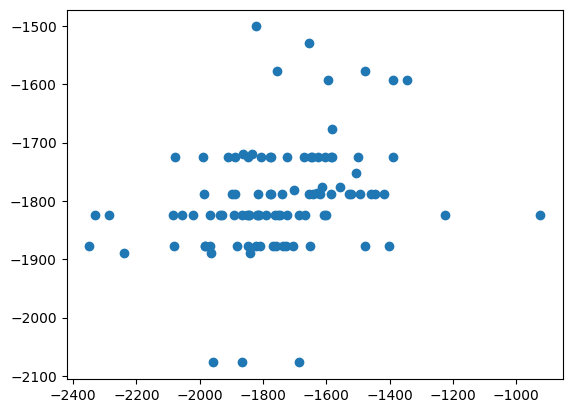

In [40]:
plt.scatter(df_test['label'].values, predictions)

In [42]:
pearsonr(df_test['label'].values, predictions)

PearsonRResult(statistic=0.28480027668863434, pvalue=0.004079810901305013)